# Graph Spectral Clustering

In this notebook, we will explore the following questions: What is the impact each individual eigenvector has on the normalized spectral clustering algorithm? While incrementing $k$, the number of clusters, how do the clusterings change? What kinds of datasets can we cluster well using spectral clustering? There will be some sections for you to fill in missing code, as well as some short answers based on the output of your code. (For all plotting questions, please include a title and axis labels.)

In [1]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

import numpy as np
import scipy as sp
from scipy import linalg
from matplotlib import cm
from tqdm import tqdm
from sklearn.cluster import KMeans, SpectralClustering

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label

## Part 1: Data generation

First, let's generate the first set of data we will use for clustering. This data will be drawn from a gaussian mixture.

For k clusters, the gaussian mixture is generated by first choosing `n_gaussian` centroids, randomly according to a normal distribution with variance `centroid_var`. For each of these centroids, the `n_pts` points are then chosen according the normal distribution with variance `cluster_var`. 

**Question 1a.** Implement the lines below in the `gaussian_mixture` function to generate data points centered around `n_gaussians` number of centroids, as described above.

In [3]:
def gaussian_mixture(n_gaussians, n_pts, dim, centroid_var=5, cluster_var=1):
    '''
    Return a matrix of gaussian vectors, one per row, where each column is a feature.
    n_gaussians: integer - number of gaussians to use in the GMM
    n_pts: integer - number of points to sample per gaussian
    dim: integer - dimensionality of points
    centroid_var: float - variance used to pick random means of each Gaussian
    cluster_var: float - variance used for each Gaussian of the mixture
    '''

    # Generate centroids of size (n_gaussians x dim), drawn from a normal
    # distribution with mean 0 and variance centroid_var.
    ### BEGIN YOUR SOLUTION ###
    centroids = np.random.normal(scale=centroid_var, size=(n_gaussians, dim))
    ### END YOUR SOLUTION ###

    points_by_gaussian = [
    # For each gaussian, sample the points and add the centroid mean.
    ### BEGIN YOUR SOLUTION ###
        np.random.normal(scale=cluster_var, size=(n_pts, dim)) + centroids[i].reshape((1, -1))
    ### END YOUR SOLUTION ###
        for i in range(n_gaussians)
    ]

    # Join the points as rows.

    return np.vstack(points_by_gaussian)

Carefully read over and understand the cell below. It will generate sliders to visualize the data we just generated above. Learning how to properly plot and visualize our data is important, as it can provide a quick way to check our work. Then, run the cell below to visualize the data we just generated. Play around with the sliders to see how changing the parameters affect the data that is being generated. As a sanity check, the data generated should match the description provided above.

In [4]:
def interactive_gaussian(n_gaussians=5, n_pts=4, d=2, centroid_var=5, cluster_var=1):
    n = n_pts * n_gaussians
    data = gaussian_mixture(n_gaussians, n_pts, d, centroid_var)
    plt.scatter(*data.T)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Sample of Gaussian Mixture")
    plt.show()

widget=interactive(interactive_gaussian, {'manual': True},
                  n_gaussians=(2, 6, 1),
                  n_pts=(2, 10, 1),
                  d=fixed(2),
                  centroid_var=(1,10,1),
                  cluster_var=(1,20,1))

widget.children[-2].description='Show Plot'
widget.children[-2].style.button_color='lightblue'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))


**Question 1b.** Describe how each of the values that are being changed by the sliders affect the plot generated. Does this match up with what you expect? If not, revisit your code above to make sure the data is being generated properly.

**Answer:**

As we increase `n_gaussians`, the number of clusters increases. Sometimes, it may appear that we have less clusters than specified due to overlapping clusters. To make the clusters more distinctive, we can lower `n_pts`, which affects the number of points within each cluster, increase `centroid_var` which will cause our centroids to be more spread out, or decrease `cluster_var`, which will cause our clusters to hug the centroids more.

**Question 1c.** Finally, let's generate the data that we will work with for parts 2 and 3 below. Use the following parameters for the data:

<center>n_gaussians=5, n_pts=4, dim=2, centroid_var=10, cluster_var=1</center><br>


Then, plot the data. Make sure the data generated matches what you would expect.

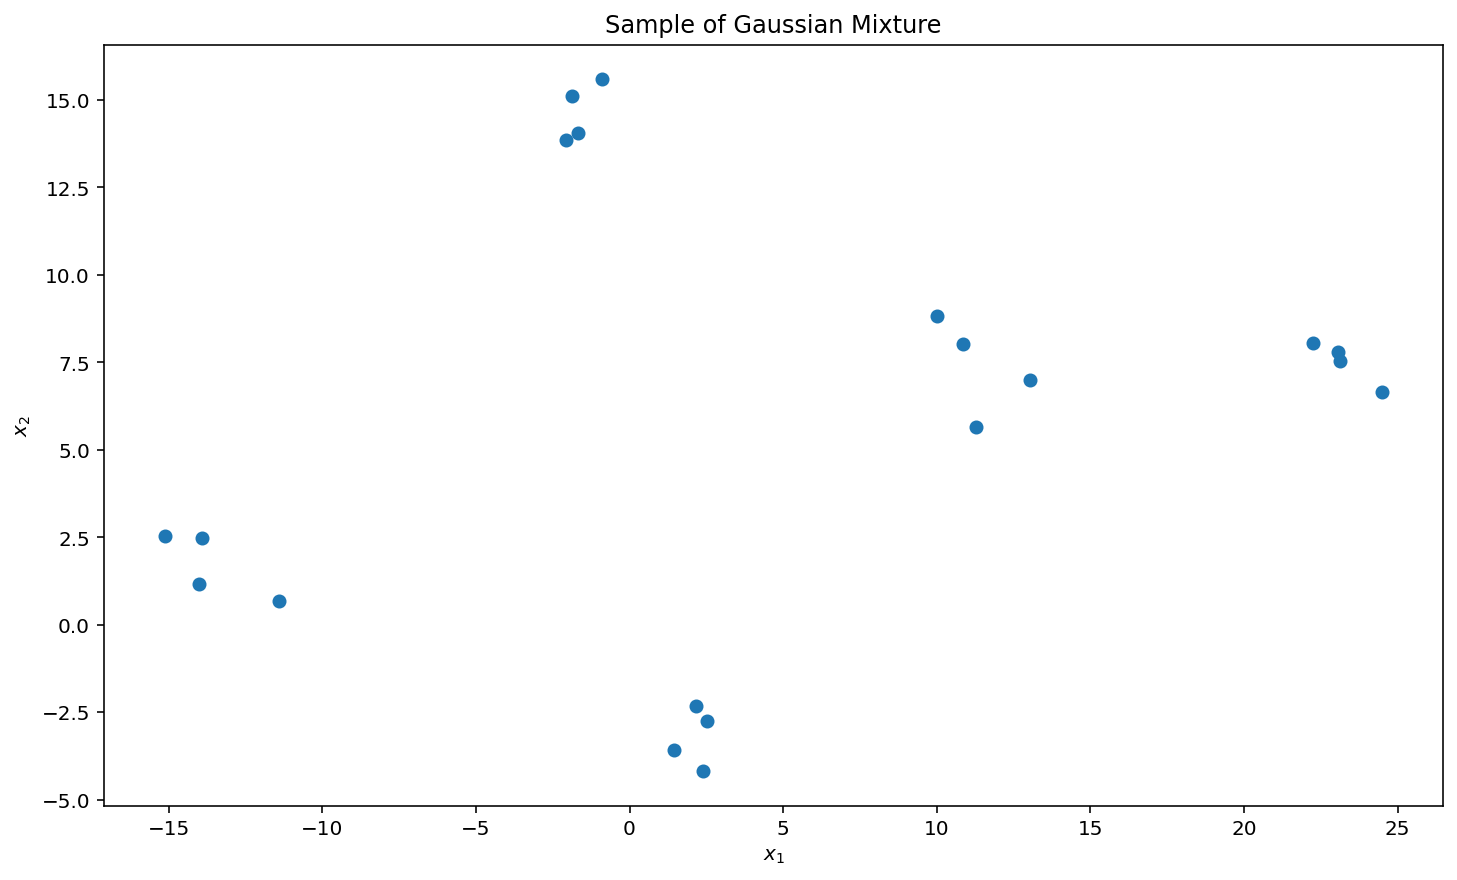

In [5]:
# n_gaussians = _
# n_pts = _
# n = _  # the total number of data points (used later)
# d = _
# centroid_var = _
# cluster_var = _

# data = _

# plt.scatter(*data.T)
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.title("Sample of Gaussian Mixture")
# plt.show()

### BEGIN YOUR SOLUTION ###
n_gaussians = 5
n_pts = 4
n = n_gaussians * n_pts
d = 2
centroid_var = 10
cluster_var = 1

data = gaussian_mixture(n_gaussians, n_pts, d, centroid_var=centroid_var, cluster_var=cluster_var)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Gaussian Mixture")
plt.show()
### END YOUR SOLUTION ###

## Part 2: The Spectral Clustering Algorithm

We will now get into the heart of the spectral clustering algorithm. Below, we have some methods that will help you further understand how the algorithm works. Some of the methods will require some code to be filled in.

This section will walk you through the steps of take your data points to create a normalized symmetric Laplacian matrix, stack the eigenvectors corresponding to the smallest eigenvalues into a matrix, then cluster the rows of this new matrix using k-means. From the cluster assignments found by k-means, we can then recover the clusters for our original points.

**Note:** This section should take the majority of time. Referring back to notes/lecture material will help you understand how the algorithms below work, and what to implement. It will save you time to first understand the algorithms before jumping into implementation.

The k-means algorithm is as follows:
1. Initialize $k$ points $c_i\in \mathbb{R}^d$ with $i=1,\dots,k$ to be the centroids of each cluster. Initializing with k-means++ picks these centroids to be as distant as possible from each other, to help ensure the correct number of clusters. More details on this in the next section.
2. Assign each data point to the closest centroid. The points corresponding to the same centroid form the clusters.
3. Move each centroid to the center of its current cluster (using the updated assignments of data).
4. Iterate steps 2 and 3 until updating the centroids in step 3 no longer changes the cluster assignments in step 2.

We improve upon this k-means algorithm by changing the initialization process. In regular k-means, the centroids are initialized randomly. It has been shown that under random initialization, the worst case runtime can be superpolynomial in runtime (not bounded above by any polynomial, bad) and the approximation found can be arbitrarily bad in comparison to the optimal clustering.

So how does the k-means++ initialization of centroids work? The first centroid is chosen arbitrarily at random and every subsequent point is chosen from the remaining points with probability proportional to the square distance from the closest already initialized centroid. It turns out that this initialization guarantees a O(log k) approximation in expectation where k is the number of clusters.

**Question 2a.** Fill in the missing code below in the `kmeans` function according to the pseudocode provided above.

In [6]:
def kmeans(data, k, iters=100, init="++"):
    '''
    data: np.ndarray - a [n, d] numpy array of n unique d-dimensional datapoints
    k: integer - number of clusters to compute
    init: string - one of ["random", "++"] to either initialize with centroids drawn from a random Gaussian, or to use kmeans++
    '''
    n, d = data.shape

    def new_assns(centroids, as_dist=False):
        ### BEGIN YOUR SOLUTION ###
        # List of [norm(data_vector[i], centroid[j]) for j=1..k]
        dists_per_centroid = [
                np.linalg.norm(data - centroids[i].reshape((1, -1)), axis=1)
                for i in range(len(centroids))
            ]
        ### END YOUR SOLUTION ###

        ### BEGIN YOUR SOLUTION ###
        # find index of the nearest centroid for each point
        # (argmin returns the *index* of the minimum item, rather than the item itself)
        if(as_dist):
            return np.min(np.stack(dists_per_centroid, axis=0), axis=0)
        else:
            return np.argmin(np.stack(dists_per_centroid, axis=0), axis=0)
        ### END YOUR SOLUTION ###

    def new_centroids(assns, centroids):
        ### BEGIN YOUR SOLUTION ###
        # for j=1..k, find all data columns matching this assignment, then average the cols
        candidate_centroids = []
        for i in range(len(centroids)):
            if(np.sum(assns == i) > 0):
                candidate_centroids.append(np.mean(data[assns==i], axis=0).reshape((1, -1)))
            else:
                candidate_centroids.append(centroids[i].reshape((1, -1)))
        ### END YOUR SOLUTION ###
        return np.vstack(candidate_centroids)

    assns = np.zeros(n)

    if(init == "random"):
        ### BEGIN YOUR SOLUTION ###
        # Initialize k x d centroids drawn from a normal distribution with the same variance as the sample variance.
        centroids = np.random.normal(scale=np.var(data), size=(k, d))
        ### END YOUR SOLUTION ###
    elif(init == "++"):
        ### BEGIN YOUR SOLUTION ###
        # Initialize k x d centroids through kmeans++
        centroids = [ data[np.random.choice(n)] ]
        for i in range(k - 1):
            dists = new_assns(centroids, as_dist=True)
            probabilities = dists**2 / (np.sum(dists**2))
            centroids.append(data[np.random.choice(n, p = probabilities)])
        ### END YOUR SOLUTION ###
    else:
        raise ValueError("Initialization must be one of ['random', '++']")


    for _ in range(iters):
        assns = new_assns(centroids)
        centroids = new_centroids(assns, centroids)
    return centroids, assns

**Question 2b.** In a real world scenario, you likely won't be required to implement k-means by hand, but instead use sklearn's built-in k-means function. To make sure you understand how to use that function, write one line of code below for how you would hypothetically cluster using sklearn's k-means function (feel free to look up documentation online).

In [7]:
### BEGIN YOUR SOLUTION ###
KMeans(n_clusters=n_gaussians).fit(data)
### END YOUR SOLUTION ###

KMeans(n_clusters=5)

In the next parts, you will implement functions needed for spectral graph clustering. As a reminder, here is the pseudocode for the algorithm:
1. Construct a similarity graph according to some well-defined metric (e.g. the Gaussian kernel, Euclidean distance, etc.).
2. Compute $L = D - A$, the unnormalized graph Laplacian.
3. Compute the symmetric normalized graph Laplacian $L_{sym} = D^{-1/2}LD^{-1/2}$
4. Compute the first $k$ eigenvectors of $L_{sym}$, where the first $k$ eigenvectors correspond to the $k$ smallest eigenvalues.
5. Construct a matrix $H$ for $L_{sym}$ with the k eigenvectors as the columns, making sure to normalize the rows to have norm 1.
6. Run k-means on the rows of $H$ to cluster the vertices.

**Question 2c.** Fill in the code below. Set the kernel to either the gaussian or exponential kernel, then populate entries in the similarity matrix (remember that diagonals should be zero).

In [8]:
def similarity_matrix(data, s=1, metric="g", kernel=None, numOfAtts=None):
    '''
    Compute an adjacency matrix given a data matrix of size (n, d). Similarities are computed using a kernel specified by the `metric` argument. 
    data: np.ndarray - (n, d) numpy array containing n datapoints having d dimensions
    s: float - scale parameter to be used in each metric. The effect of `s` depends on choice of metric.
    metric: one of ["g", "e", "k"] - choose a metric for the data:
        "g" for Gaussian: d(x, y) = exp(-|x-y|^2 / 2 (s^2)). The scale `s` controls standard deviation. 
        "e" for Exponential: d(x, y) = exp(-|x-y|/s). The scale `s` is the parameter of the exponential.
        "eps" for Epsilon neighbors: d(x, y) = |x-y| if less than epsilon, 0 otherwise
        "k" for Kernel: use an arbitrary kernel, given by the `kernel` argument.
    kernel: K(x, y, s) -> \R+ - an arbitrary distance function between two points of the same dimension with a given scale.

    @returns an (n, n) np.ndarray adjacency matrix representing a similarity graph for the data
    '''
    n = len(data)
    similarity_matrix = np.zeros((n, n))

    if(metric == "g"):
        # assign `kernel` to the gaussian kernel
        ### BEGIN YOUR SOLUTION ###
        kernel = lambda x, y, s : np.exp(- np.linalg.norm(x - y) ** 2 / (2 * s**2))
        ### END YOUR SOLUTION ###
    elif(metric == "e"):
        # assign `kernel` to the exponential kernel
        ### BEGIN YOUR SOLUTION ###
        kernel = lambda x, y, s : np.exp(- np.linalg.norm(x - y) / s)
        ### END YOUR SOLUTION ###
    elif(metric == "eps"):
        def eps_threshold(x, eps):
            return x if x < eps else 0
        kernel = lambda x, y, s : eps_threshold(np.linalg.norm(x-y), s)
    elif(metric == "k"):
        assert kernel is not None, "Must pass a kernel function to use kernelized similarity metric"
    else:
        raise ValueError("Similarity metric must be one of [g, e, k]")


    for i in range(n):
        for j in range(n):
            ### BEGIN YOUR SOLUTION ###
            if(i == j):
                similarity_matrix[i][j] = 0
            else:
                similarity_matrix[i][j] = kernel(data[i], data[j], s)
            ### END YOUR SOLUTION ###

    return similarity_matrix

**Question 2d.**  Complete the function to return a Laplacian matrix given the adjacency matrix of a graph.

In [9]:
def laplacian_matrix(graph_weights):
    '''
    Return a graph laplacian and degree matrix given the graph's edge weights
    graph_weights: np.ndarray - an (n, n) dense graph adjacency matrix
    @returns a tuple (laplacian, degree) containing the (n, n) graph laplacian and the (n,) diagonal elements of the degree matrix
    '''
    ### BEGIN YOUR SOLUTION ###
    degree = np.sum(graph_weights, axis=0)
    laplacian = np.diag(degree) - graph_weights
    ### END YOUR SOLUTION ###
    return laplacian, degree

**Question 2e.** Compute the eigenvalues and normalized eigenvectors for the symmetric Laplacian.

In [10]:
def spectral_clustering(data, k, with_eigen = False, kmeans_iters = 100, numOfAtts=None, metric = None, **kwargs):
    '''
    Args:
        data (np.ndarray): (n,d) numpy array consisting of n d-valued points
        k (integer): desired number of clusters
        with_eigen (:obj:bool, optional) - if True, will also return a tuple (evalues, evecs) of the k Laplacian eigenpairs
        metric: one of ["g", "e", "k"] - choose a metric for the data:
            "g" for Gaussian: d(x, y) = exp(-|x-y|^2 / 2 (s^2)). The scale `s` controls standard deviation.
            "e" for Exponential: d(x, y) = exp(-|x-y|/s). The scale `s` is the parameter of the exponential.
            "k" for Kernel: use an arbitrary kernel, given by the `kernel` argument.
    Returns:
        A list of (n,) integers of the cluster assignments of each data point. If with_eigen=True, also returns eigenvalues and eigenvectors of the Laplacian.
    1. use a specialized algorithm to compute indicator vectors
    2. cluster the eigenvectors with k-means
    ''' 

    data_sim = similarity_matrix(data, **kwargs, numOfAtts = numOfAtts)
    n,d = data_sim.shape
    laplacian, degree = laplacian_matrix(data_sim)

    ### BEGIN YOUR SOLUTION ###
    # compute the symmetric laplacian
    dhalfinv = np.diag(np.sqrt(1 / degree))       # compute D^(-1/2)
    lsym = dhalfinv @ laplacian @ dhalfinv        # Construct the symmetric laplacian
    # compute the first k eigenvectors/eigenvalues of lsym
    # note that because it is symmetric, we can do this efficiently with sp.linalg.eigh
    S, U = sp.linalg.eigh(lsym, eigvals=(0, k-1)) # S, U = sp.linalg.eigh(__, eigvals=__)
    U = U / sp.linalg.norm(U, axis=1).reshape((-1, 1)) # normalize rows of the matrix
    ### END YOUR SOLUTION ###

    centroids, assns = kmeans(U, k, iters=kmeans_iters)
    if(with_eigen):
        return (assns, (S, U))
    else:
        return assns

**Question 2f.** Again, implement spectral clustering below, using sklearn. Print the labels of the data generated from the Gaussian mixture.

In [11]:
### BEGIN YOUR SOLUTION ###
clustering = SpectralClustering(n_clusters=n_gaussians).fit(data)
print('Labels: ' + str(clustering.labels_))
### END YOUR SOLUTION ###

Labels: [2 2 2 2 3 3 3 3 1 1 1 1 4 4 4 4 0 0 0 0]


## Part 3: Extracting and Visualizing Eigenvectors

Now, let's visualize the eigenvectors. The following plot shows eigenvectors (of the Graph Laplacian) in increasing order of the corresponding eigenvalues. The spectral clustering function is called with the exponential kernel (one of the similarity kernels that can be used for spectral clustering), to provide a graph visualizing the eigenvectors.

The color map used is viridis. Purple represents large negative numbers, and it ranges up in backwards rainbow order to yellow, which represents large positive numbers.

For the following questions, comment your observations about the extraction and visualization of the eigenvectors that just occurred. 

The cluster assignments for 5 clusters:  [3 3 3 3 1 1 1 1 4 4 4 4 0 0 0 0 2 2 2 2]


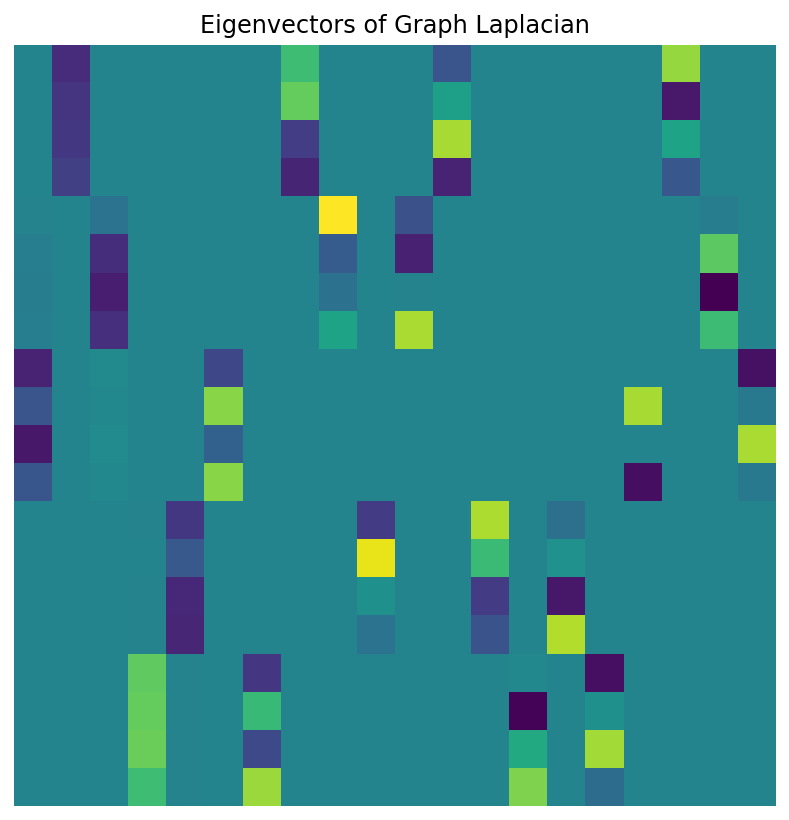

In [12]:
assns, _ = spectral_clustering(data, k=5, with_eigen=True, metric="e")
print("The cluster assignments for 5 clusters: ", assns)
_, (evals, evecs) = spectral_clustering(data, k=n, with_eigen=True, metric="e")
plt.imshow(evecs)
# print(evecs) ## uncomment this part of the code to see what the entries of the matrix are
plt.axis('off')
plt.title("Eigenvectors of Graph Laplacian")
plt.show()

**Question 3a.** Based on this visualization, what do you notice about the eigenvectors of the graph laplacian?

**Answer:**

The first 5 eigenvectors have consecutive blocks of roughly the same value, while eigenvectors past the first 5 have the same stripe locations but are different colors. This indicates that after the eigenvalues distinguish between the first 5 clusters (because we generated data with 5 Gaussian mixtures), the algorithm starts clustering more finely within each Gaussian mixture. 


**Question 3b.** Next, plot the eigenvalues of the similarity graph Laplacian. You should generate a plot showing eigenvalue growth rate. 

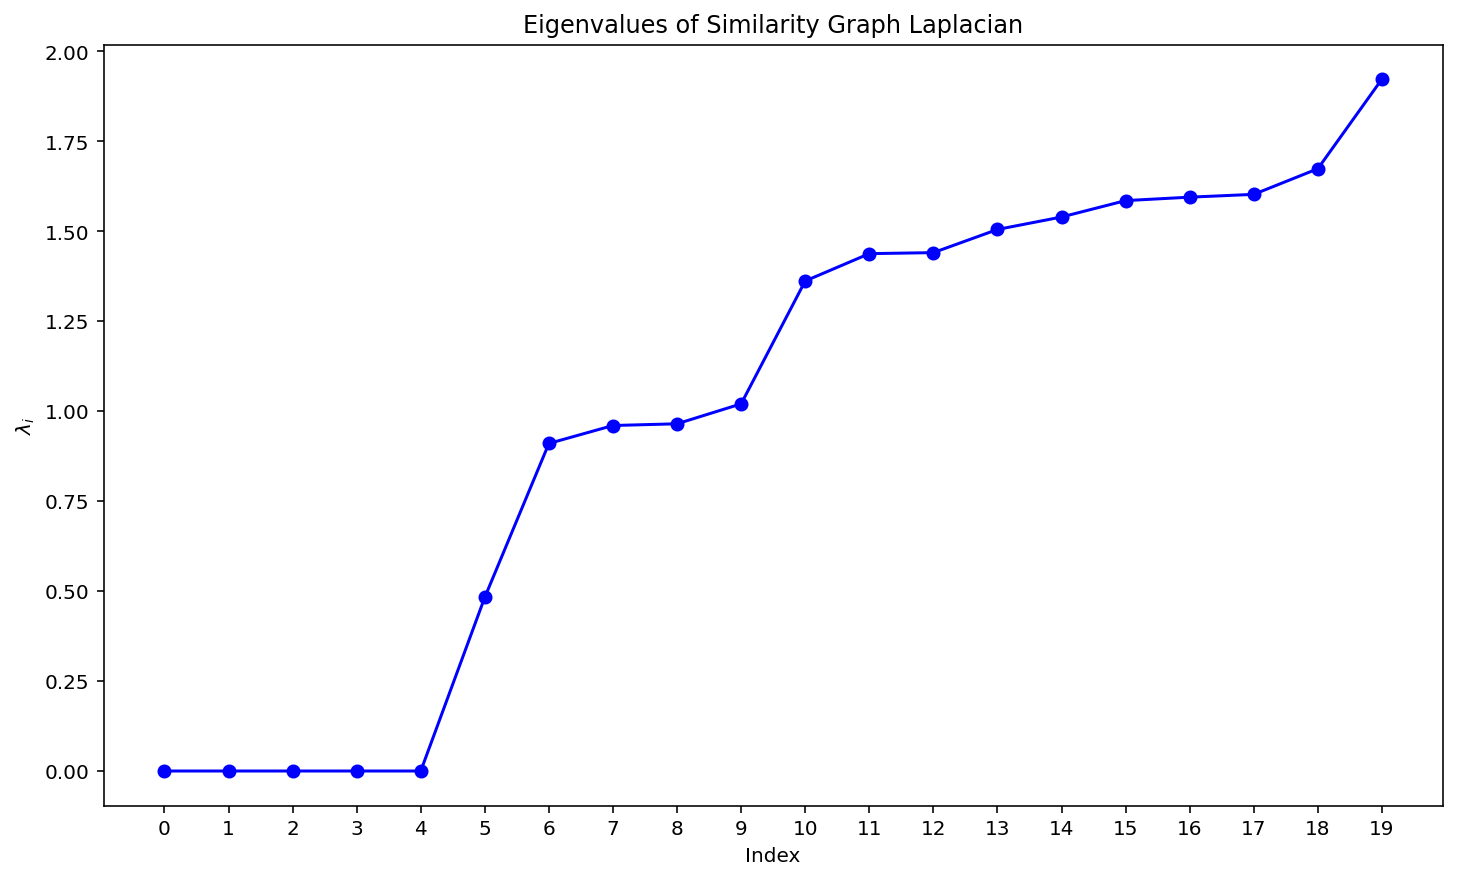

In [13]:
### BEGIN YOUR SOLUTION ###
plt.plot(evals, "bo-")
plt.xlabel("Index")
plt.ylabel("$\lambda_i$")
plt.xticks(range(n))
plt.title("Eigenvalues of Similarity Graph Laplacian")
plt.show()
### END YOUR SOLUTION ###

**Question 3b.** What do you notice about the eigenvalues? (Hint: how many eigenvalues are nearly zero?) How can looking at the eigenvalue plot inform us about good $k$'s to choose?

**Answer:**

Because there are `n_gaussian` clusters, the first `n_gaussian` eigenvalues are nearly zero. If we didn't know that there are `n_gaussian` clusters, by looking at the graph of the eigenvalues, a good guess for k would be either 5 or 6 clusters (corresponds to index 4 and 5) because there is a massive leap in the value of the eigenvalue at index 6. 

### Cumulative Clusters

The cells below will generate subplots, which show classification decisions using a certain number of eigenvectors of the normalized graph Laplacian. These are called cumulative clusters, in the sense that plot $(i+1)$ includes all vectors used to cluster plot $(i)$, plus an additional vector.

In [14]:
cmap = cm.get_cmap("tab20")
# Note: if n > 20, then multiple indices end up in the same color bin, inducing a seemingly bad clustering
unif_colors = [cmap(intensity) for intensity in np.linspace(0, 1, n)] 

100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


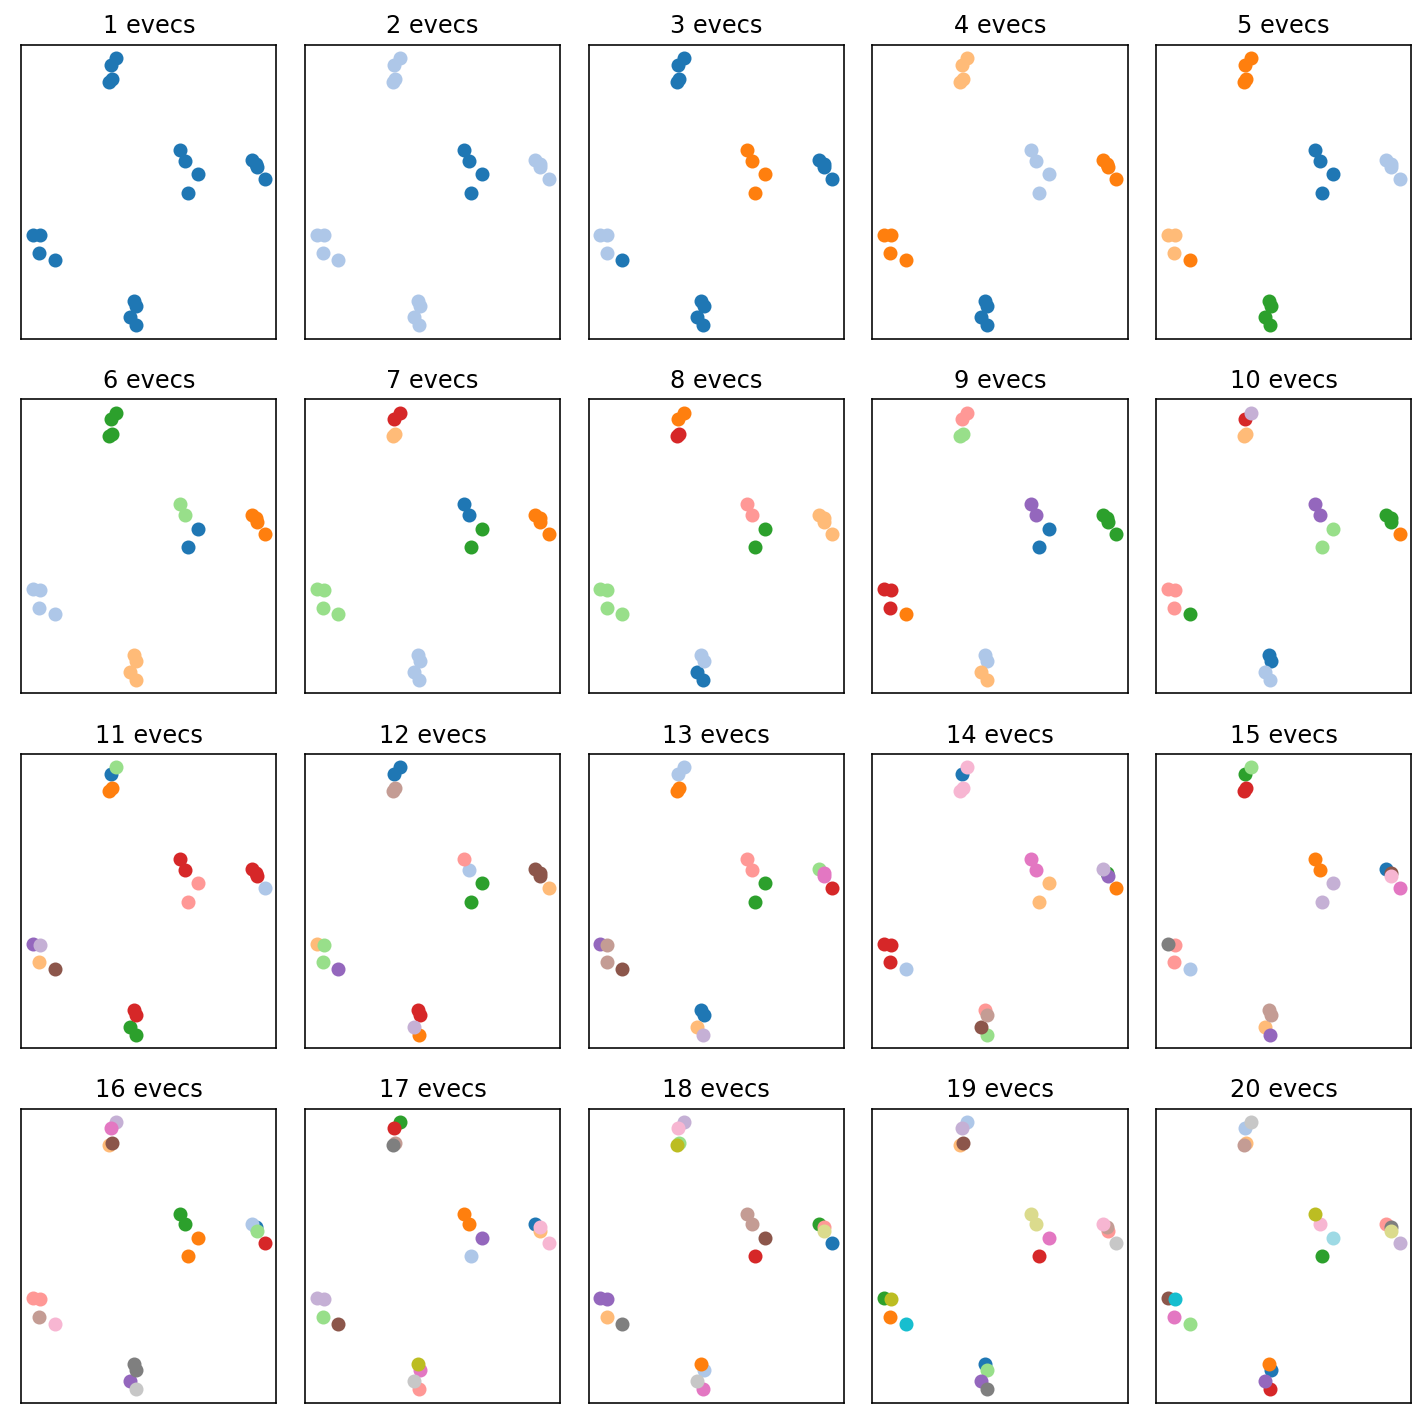

In [15]:
r = n_pts
c = n_gaussians
# r * c = N
for i in tqdm(range(1,n+1)):
    #evecs = np.fliplr(evecs)
    _, assns = kmeans(evecs[:, :i], i, iters=100)
    data_clusters = [ data[assns == clss].T for clss in range(i) ]
    plt.subplot(r, c, i)
    plt.title(f"{i} evecs")
    plt.gca().set_xticks([], [])
    plt.gca().set_yticks([], [])

    for j, data_cluster in enumerate(data_clusters):
        plt.scatter(*data_cluster, color=unif_colors[j])

plt.gcf().set_size_inches(10, 10)
plt.tight_layout()
plt.show()

**Question 3c.** How is the number of clusters $k$ related to how well the algorithm clusters? Which $k$ does the best in this case and why?

**Answer:**

$k$ is a hyperparameter that we choose. It is critical that we choose the right one because looking at some higher numbers, the algorithm doesn't do too well. Since our data was generated from a mixture of gaussians using 5 centroids, it would make the most sense for $k=5$ to be the best $k$.

It's important to understand how these cluster assignments come to be from the eigenvectors of the graph laplacian. We cluster the rows of this matrix using k means to get the cluster assignments.

It's also important to note that we used k-means++ to cluster the rows of our eigenvector matrix instead of the canonical k-means. The difference lies in the convergence times. In k-means++ we initialize the centroids to be as far away as possible and this simple change in initialization helps us reach good solutions. Sometimes if we get really unlucky with our initialization for k-means we end up with either the wrong cluster assignments, or it takes a lot longer to converge to the correct solution.

## Part 4: Classifying Harder Datasets

For the last part, we will move on to classifying more difficult datasets, in which the clusters are not as obvious. We will observe how well k-means and spectral clustering can identify the moons dataset. From the sklearn documentation, this is a 'simple toy dataset to visualize clustering and classification algorithms. Enjoy!

In [16]:
from sklearn.datasets import make_moons

**Question 4a.** Plot a scatterplot of the moons data using the `make_moons` function from sklearn.

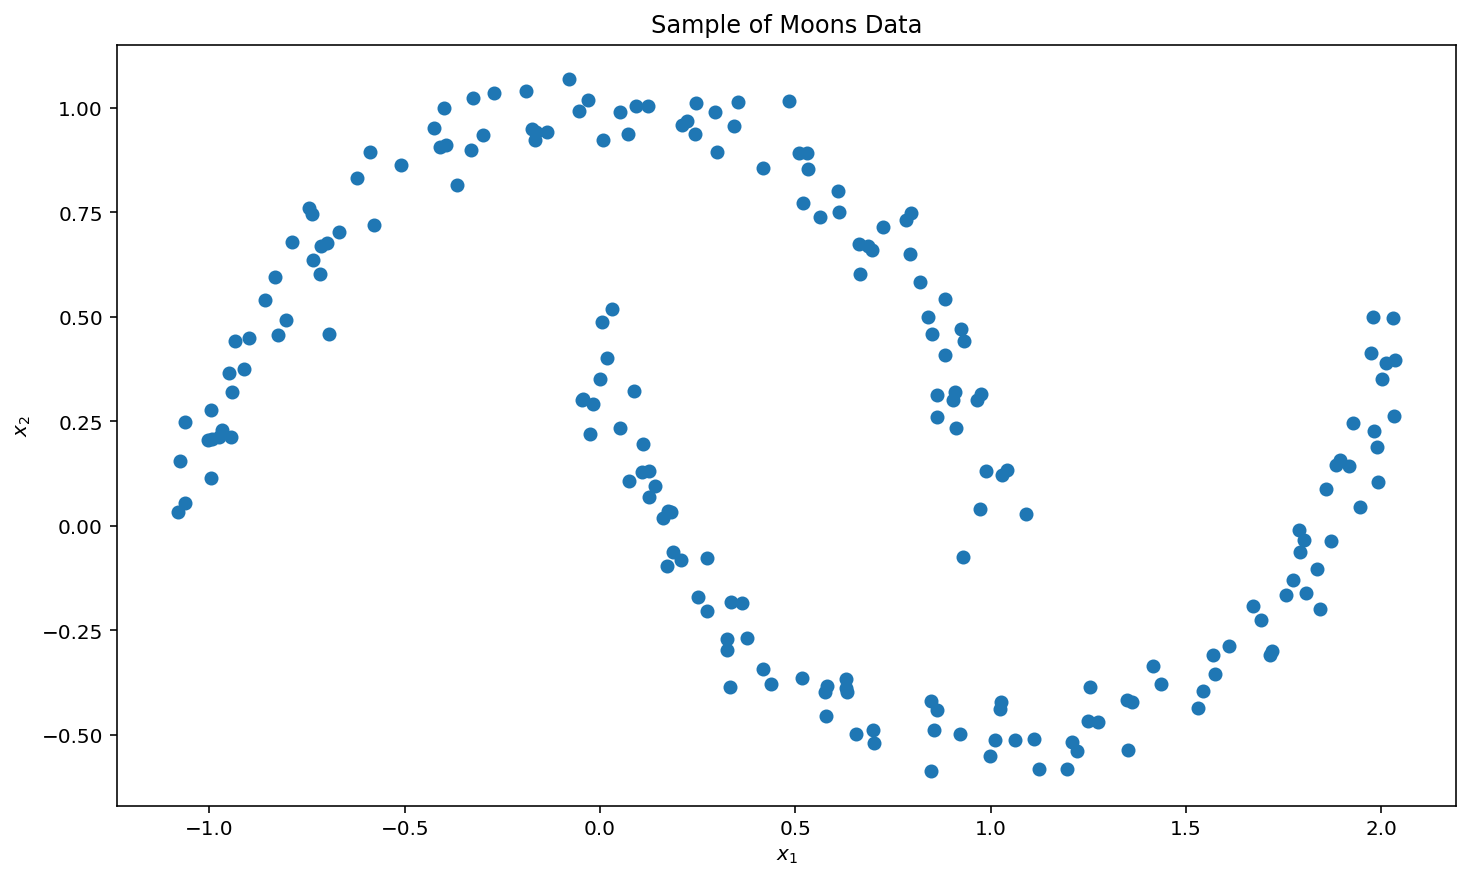

In [17]:
moon_data, _ = make_moons(200, noise=0.05)

### BEGIN YOUR SOLUTION ###
plt.scatter(*moon_data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Moons Data")
plt.show()
### END YOUR SOLUTION ###

**Question 4b.** Based on your visualization, why do you think clustering techniques like k-means will not work on the moons dataset? Why is spectral graph clustering suitable to use on this dataset?

**Answer:**

This is because k-means clusters based on Euclidean distance, which gives us clusters that look like circles. Since this two moons dataset doesn't have clusters that look like circles, k-means will not work. On the other hand, spectral graph clustering is suitable because we can use different kernels such as the RBF kernel to define similarity between the points. The RBF kernel ($e^{-\frac{\|x-y\|^2}{2\sigma^2}}$) allows us to prioritize local points over points that are further away given that we choose a good $\sigma$.

Run the next cell to see how K-means will cluster the two moons dataset. Make sure your answer, and the plot below line up.

Text(0.5, 1.0, 'Clustering with K-means')

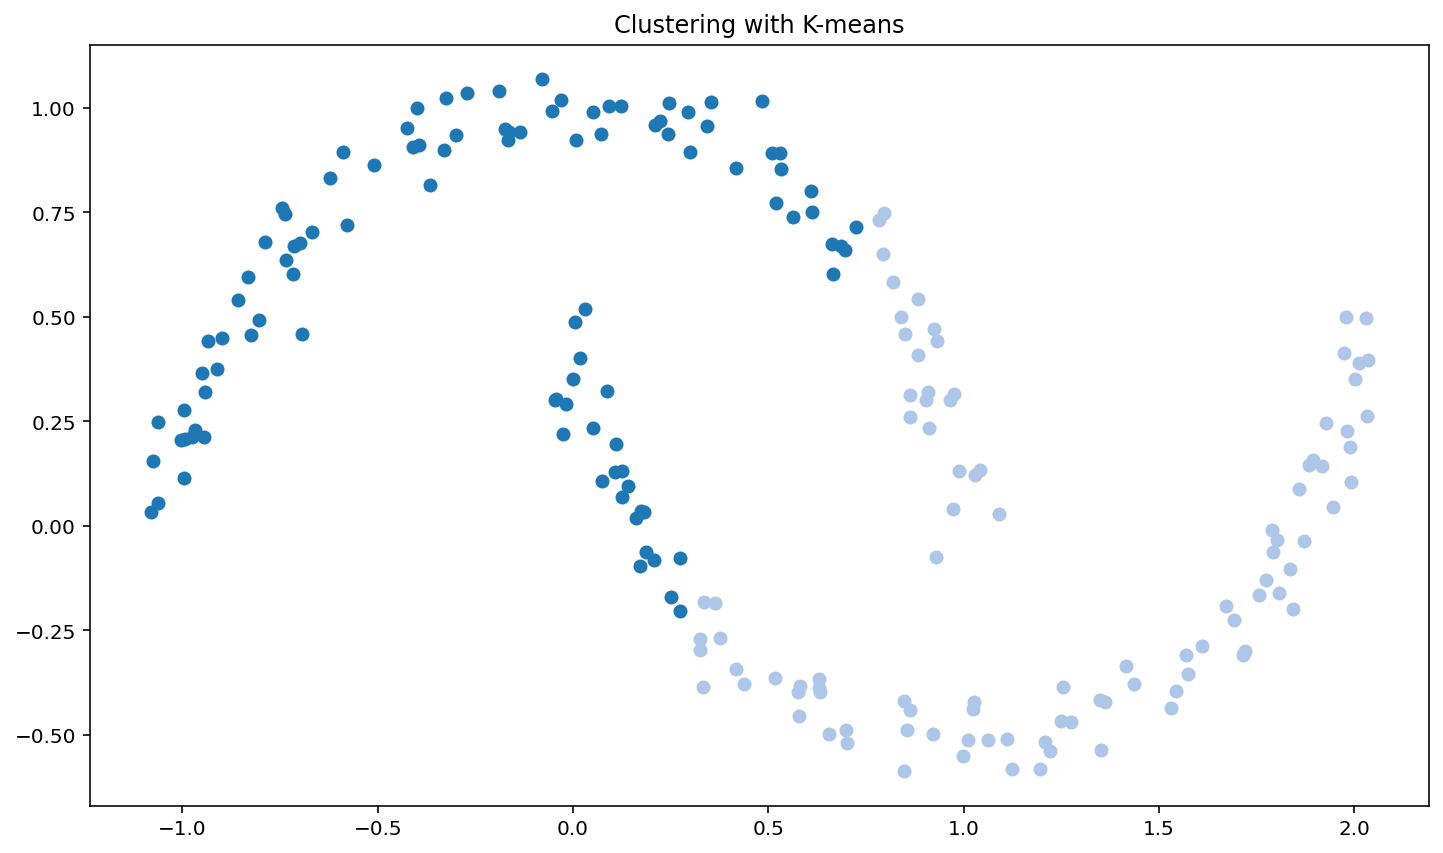

In [18]:
_, assns = kmeans(moon_data, k=2) # _, assns = 

moon_data_clusters = [ moon_data[assns == clss].T for clss in range(n_gaussians) ]
for j, moon_data_cluster in enumerate(moon_data_clusters):
    plt.scatter(*moon_data_cluster, color=unif_colors[j], label=f"{j}")

plt.title("Clustering with K-means")

**Question 4c.** Fill in the code below to implement a slider for values of $\sigma$, which range from 0.01 to 1, with step size of 0.01. Play around with the slider. You should be able to find a range of values which will cluster the two moons dataset correctly.

In [19]:
def interactive_gaussian_kernel(data=moon_data, sigma=0.01):
    ### BEGIN YOUR SOLUTION ###
    assns = spectral_clustering(data, k=2, metric="g", s=sigma) # assns = 
    data_clusters = [ moon_data[assns == clss].T for clss in range(n_gaussians) ]
    for j, data_cluster in enumerate(data_clusters):
        plt.scatter(*data_cluster, color=unif_colors[j], label=f"{j}")

    ### END YOUR SOLUTION ###
    plt.title("Spectral Clustering with Gaussian Kernel, $\sigma=$" + str(sigma))

### BEGIN YOUR SOLUTION ###
widget=interactive(interactive_gaussian_kernel, {'manual': True},
                  data=fixed(moon_data),
                  sigma=(0.01,1,0.01))

widget.children[-2].description='Show Plot'
widget.children[-2].style.button_color='lightblue'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))
### END YOUR SOLUTION ###

**Question 4d.** Comment your observations on how the hyperparameter $\sigma$ affects the cluster assignments. What values of $\sigma$ cluster the two moons correctly?

**Answer:** When $\sigma$ is from 0.02 to 0.2, spectral graph clustering does well. On the other hand, when the hyperparameter $\sigma$ is too large or too small, graph spectral clustering does roughly the same as K-means. 

Notice that as $\sigma$ grows large, the clustering looks more like what we get from k-means while when $\sigma$ is small, the clustering looks pretty arbitrary. 

**Question 4e.** How do the values of $\sigma$ affect the cluster assignments?

**Answer:** The $\sigma$ affects the similarity between points. When $\sigma$ is too large, $e^{-\frac{\|x-y\|^2}{2\sigma^2}}$ approaches zero for virtually all values. On the other hand, when $\sigma$ is too small, $e^{-\frac{\|x-y\|^2}{2\sigma^2}}$ is large for most values. In both scenarios, the kernel doesn't pull apart the differences between items belonging to each moon. A good $\sigma$ will allow us to distinguish between points that lie within a cluster and points that are further away (lie in different clusters).
